In [1]:
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
class Parse_String:
    """
    A Class to represent a boolean function. It stores the expression in an easy to use format and also
    contains the needed functions to operate on the expression.
    
    """
    
    
    def __init__(self,expression, verbose = True): 
        """
        Initializes an object and stores the expression in the required format for easy use.
        
        """
        
        try:
            terms = expression.replace(" ","").split("+")

            for i in range(len(terms)):
                terms[i] = self.breakdown(terms[i])

            self.expression = terms
            if(verbose):
                print("successfully parsed [{}]\n".format(self.display()))
            
        except:
            print("Given expression is invalid")
            

    def calculate_cofactor(self, term, show_steps=False, verbose = True):
        """
        Calculates the cofactors of the expression by calling calculate_single_cofactor reccursively.
        
        """
        
        cofactor = self.expression
        for i in self.breakdown(term): #Calculate cofactors one variable at a time
            cofactor = self.calculate_single_cofactor(i,cofactor) 
            
            if(show_steps): #Option to show intermediate steps
                print("cofactor after", i , "is" , [self.display(cofactor)])
                
            if(cofactor == [['1']]): #If any SoP term = 1, remaining terms need not be calculated
                break
        
        if verbose:
            print("Cofactor of [{}] wrt [{}] is [{}]".format(self.display(self.expression),self.display(term),self.display(cofactor)))
        
        return(self.display(cofactor))
        
    def calculate_single_cofactor(self,term,expression = None):
        """
        Calculates the cofactor of the given expression with respect to the given term.
        
        """
        
        if (expression == None):
            expression = self.expression
            
        cofactor = []
        for word in expression:
            if(term in word): #Remove variable from term if variable is present (Since A*1 = A)
                word = [ i for i in word if i!=term]

            if(word == []): #If all terms are removed(i.e., all terms are 1), total value is 1
                cofactor = [['1']]
                break
            
            if(self.invert(term) not in word): #If inverse is present in term, then term value is 0 and hence skipped
                cofactor = cofactor + [word]
            
        if(len(cofactor)==0): #If all terms are skipped(all terms have value 0), total value is 0
            cofactor = [['0']]
                
        return(cofactor)
        
        
    def breakdown(self,term):
        """
        Breaks down a product term into a list of variables.
        Ex: AB'C is broken down into [A,B',C] .
        
        """
        out = []
        for val in term:
            if(val=="'"):
                if("'" in out[-1]):
                    out[-1] = out[-1][:-1]
                else:
                    out[-1] = out[-1] + "'"
            else:
                out = out + [val]
        return(out)
    
    def display(self,expression = None):
        """
        Converts the expression from a list of variables into an easy-to-read SoP string format.
        Ex: [[A,B',C],[D]] is converted to AB'C + D.
        
        """
        if (expression == None): #Display orginal expression by default
            expression = self.expression
        
        if (type(expression[0]) is not list): #In case only one product term exists in SoP
            expression = [expression]
        
        out = ' + '.join([''.join(term) for term in expression])
        return(out)
    
    def invert(self,Var):
        """
        Inverts the value of a single variable.
        EX: A is converted to A' and vice versa.
        
        """
        if(Var[-1]=="'"):  
            Var=Var.replace("'","")
        else:
            Var = Var+"'"
        return(Var)

    def unique_variables(self,expression = None):
        """
        Returns a list of unique variables used in the boolean expression.
        
        """
        if (expression == None): #Read the orginal expression by default
            expression = self.expression
            
        output = list(set(self.display(expression).replace("+","").replace(" ","").replace("'","")))
        return(output)          

In [3]:
##Inputs
SoP = "AC + A'BC' + AB' + DAB' + AEFG' + G + EC"  #Define Input Boolean Expression
cofactor_term = "C'AF" #Variable with respect to calculate cofactor 

##Execution
Boolean_expression = Parse_String(SoP) #Create Boolean expression variable
Boolean_expression.calculate_cofactor( cofactor_term, show_steps = False); #Calculate and display cofactor

successfully parsed [AC + A'BC' + AB' + DAB' + AEFG' + G + EC]

Cofactor of [AC + A'BC' + AB' + DAB' + AEFG' + G + EC] wrt [C'AF] is [B' + DB' + EG' + G]


In [4]:
class bdd_node:
    """
    A class for representing nodes of the ROBDD
    
    """
    n_nodes = 0; #Count for total number of nodes created in the tree
    
    def __init__(self,name = None,expression = None,zero_child=None,one_child=None,parent=None,Node_number=None,child_type=None):
        self.name = name
        self.zero_child = zero_child
        self.one_child = one_child
        self.parent = parent
        self.expression = expression
        bdd_node.n_nodes = bdd_node.n_nodes + 1
        self.Node_number = Node_number
        self.child_type = child_type
   
    def __del__(self):
        bdd_node.n_nodes = bdd_node.n_nodes - 1
        
    def status(self):
        print("-------------Status--------------")
        print("Name = ",self.name)
        print("zero_child",self.zero_child)
        print("one_child",self.one_child)
        print("parent",self.parent)
        print("expression",self.expression)
        print("n_nodes",bdd_node.n_nodes)
        print("Node_number",self.Node_number)
        print("child_type",self.child_type)
        print("----------------------------------")
        
def Generate_ROBDD(expression,variables=None):
    """
    Calculates and plots a Reduced ordered binary decision diagram of the given boolean expression.
    
    """
    
    parsed_expression = Parse_String(expression,verbose = 0)
    
    if (variables == None): #Use provided variable order if available
        variables = parsed_expression.unique_variables()
    
    Nodes = [bdd_node(variables[0],expression=expression,Node_number=0)]
    
    for pos,node in enumerate(Nodes):
        parent = Parse_String(node.expression,verbose=False)
        
        if((node.expression != "0") and (node.expression != "1")):
            
            child1 = parent.calculate_cofactor(node.name+"'",verbose=False)             
            if((child1== '0') or (child1== '1')):
                node_name_1 = child1
            else:
                node_name_1 = variables[variables.index(node.name)+1]
            
            child2 = parent.calculate_cofactor(node.name,verbose=False) 
            if((child2== '0') or (child2== '1')):
                node_name_2 = child2
            else:
                node_name_2 = variables[variables.index(node.name)+1]

            
            Nodes.append(bdd_node(node_name_1,child1,parent=node.Node_number,Node_number = len(Nodes),child_type = 0))
            Nodes.append(bdd_node(node_name_2,child2,parent=node.Node_number,Node_number = len(Nodes) ,child_type = 1))
            
            Nodes[pos].zero_child = len(Nodes)-2
            Nodes[pos].one_child = len(Nodes)-1
                        
    Optimised_graph = []
    for node in Nodes[::-1]:
        check = [((ele.name==node.name) and (ele.zero_child == node.zero_child) and (ele.one_child == node.one_child)) for ele in Optimised_graph]
        if any(check):
            #print("Node already exists:")
            #Optimised_graph[check.index(True)].status()
            #node.status()
            if(node.parent!=None):
                if(node.child_type==0):
                    Nodes[node.parent].zero_child = Optimised_graph[check.index(True)].Node_number
                    #print("Modified zero_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[check.index(True)].Node_number))
                    #Nodes[node.parent].status()
                else:
                    Nodes[node.parent].one_child = Optimised_graph[check.index(True)].Node_number
                    #print("Modified one_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[check.index(True)].Node_number))
                    #Nodes[node.parent].status()
                    

        else:
            #print("*********************************Adding new node*******************************")
            if((node.one_child == node.zero_child) and  (node.parent!=None) and (node.expression not in ['0','1'])):
                Optimised_graph[node.one_child].parent = node.parent
                if(node.child_type):
                    Nodes[node.parent].one_child = node.one_child
                else:
                    Nodes[node.parent].zero_child = node.one_child
                print("killed ",node.expression,":",node.name)
                
            else:    
                
                Optimised_graph.append(node)
                Optimised_graph[-1].Node_number = len(Optimised_graph)-1
                if(node.parent!=None):
                    #print("Valid Parent for new node")
                    if(Optimised_graph[-1].child_type==0):
                        Nodes[node.parent].zero_child= Optimised_graph[-1].Node_number
                        #print("Modified zero_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[-1].Node_number))
                        #Nodes[node.parent].status()
                    else:
                        Nodes[node.parent].one_child= Optimised_graph[-1].Node_number
                        #print("Modified one_child of {} to {}".format("["+Nodes[node.parent].expression+"]:"+Nodes[node.parent].name,Optimised_graph[-1].Node_number))
                        #Nodes[node.parent].status()
                    
            #print("Added new node at position {}:".format(Optimised_graph[-1].Node_number),Optimised_graph[-1].expression)
            #node.status()
            
        #print("Current list of nodes is:{}\n".format([i.expression for i in Optimised_graph]))
        
    
    print("******************  CONSTRUCTING GRAPH **********************")
    G = nx.DiGraph()
    for position,node in enumerate(Optimised_graph):
        G.add_node(node.expression+"__"+str(node.Node_number))            
        if((node.expression != '0') and (node.expression != '1')):
            #Optimised_graph[node.Node_number].status()
            print("Edge from node {} to {}".format(node.Node_number,node.zero_child))
            print("Edge from node {} to {}".format(node.Node_number,node.one_child))
            G.add_edge(node.expression+"__"+str(node.Node_number),Optimised_graph[node.zero_child].expression+"__"+str(Optimised_graph[node.one_child].Node_number), Input=0)
            G.add_edge(node.expression+"__"+str(node.Node_number),Optimised_graph[node.one_child].expression+"__"+str(Optimised_graph[node.one_child].Node_number), Input=1)
            
    edge_labels = dict([((n1, n2), d['Input']) for n1, n2, d in G.edges(data=True)]) 
    pos = graphviz_layout(G, prog="dot")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5,font_color='red', font_size=16, font_weight='bold')

    nx.draw(G, with_labels=True,pos=pos,style = "dashed")

killed  D' + D : D
killed  D' + D : D
******************  CONSTRUCTING GRAPH **********************
Edge from node 2 to 1
Edge from node 2 to 0
Edge from node 3 to 1
Edge from node 3 to 0
Edge from node 4 to 1
Edge from node 4 to 2
Edge from node 5 to 3
Edge from node 5 to 0
Edge from node 6 to 3
Edge from node 6 to 4
Edge from node 7 to 6
Edge from node 7 to 5


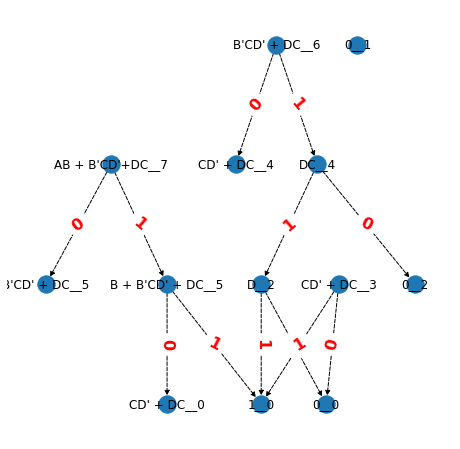

In [5]:
plt.figure(figsize=(8,8))
Generate_ROBDD("AB + B'CD'+DC","ABCD")
plt.show()

In [6]:
###Backup
# class bdd_node:
#     """
#     A class for representing nodes of the ROBDD
    
#     """
#     n_nodes = 0; #Count for total number of nodes created in the tree
    
#     def __init__(self,name = None,expression = None,zero_child=None,one_child=None,parent=None,Node_number=None):
#         self.name = name
#         self.zero_child = zero_child
#         self.one_child = one_child
#         self.parent = parent
#         self.expression = expression
#         bdd_node.n_nodes = bdd_node.n_nodes + 1
#         self.Node_number = Node_number
   
#     def __del__(self):
#         bdd_node.n_nodes = bdd_node.n_nodes - 1
        
#     def status(self):
#         print("-------------Status--------------")
#         print("Name = ",self.name)
#         print("zero_child",self.zero_child)
#         print("one_child",self.one_child)
#         print("parent",self.parent)
#         print("expression",self.expression)
#         print("n_nodes",bdd_node.n_nodes)
#         print("Node_number",self.Node_number)
#         print("----------------------------------")
        
# def Generate_ROBDD(expression,variables=None):
#     """
#     Calculates and plots a Reduced ordered binary decision diagram of the given boolean expression.
    
#     """
    
#     parsed_expression = Parse_String(expression,verbose = 0)
    
#     if (variables == None): #Use provided variable order if available
#         variables = parsed_expression.unique_variables()
    
#     Nodes = [[bdd_node(variables[0],expression=expression)]]
    
#     for i in range(len(variables)):
#         Nodes.append([])
#         for parent_index in range(len(Nodes[-2])):
#             parent = Parse_String(Nodes[-2][parent_index].expression,verbose=False)
            
#             if((Nodes[-2][parent_index].expression != "0") and (Nodes[-2][parent_index].expression != "1")):

#                 Nodes[-1]=Nodes[-1]+ [bdd_node(variables[i],parent.calculate_cofactor(variables[i]+"'",verbose=False),parent=parent_index)]
#                 Nodes[-2][parent_index].zero_child = len(Nodes[-1])-1                
                
#                 Nodes[-1]=Nodes[-1]+ [bdd_node(variables[i],parent.calculate_cofactor(variables[i],verbose=False),parent=parent_index)]
#                 Nodes[-2][parent_index].one_child = len(Nodes[-1])-1

#     Optimised_graph = []
#     for i in Nodes[::-1]:
#         for node in i:
#             if any((ele.name==node.name and ele.zero_child == node.zero_child and ele.one_child == node.one_child) for ele in Optimised_graph):
                
            
            
            
#     G = nx.DiGraph()
    
#     for n_layer,layer in enumerate(Nodes):
#         for position,node in enumerate(layer):
#             G.add_node(node.expression,)            
#             if((node.expression != '0') and (node.expression != '1')):
#                 G.add_edge(node.expression,Nodes[n_layer+1][node.zero_child].expression)
#                 G.add_edge(node.expression,Nodes[n_layer+1][node.one_child].expression)
                
#     pos = graphviz_layout(G, prog="dot")
#     nx.draw(G, with_labels=True,pos=pos,style = "dashed")